In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Standard imports
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
# Ionpy imports
from ionpy.analysis import ResultsLoader
# Local imports
from ese.analysis.analyze_inf import load_cal_inference_stats

sns.set_style("darkgrid")
sns.set_context("talk")
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root:
        - '/storage/vbutoi/scratch/ESE/inference/10_26_24_OCTA_Benchmark'
        - '/storage/vbutoi/scratch/ESE/inference/10_26_24_ISLES_Benchmark'
        - '/storage/vbutoi/scratch/ESE/inference/10_26_24_Roads_FULLRES_Benchmark'
        - '/storage/vbutoi/scratch/ESE/inference/10_28_24_WMH_AllHospitals_Benchmark'
    inference_group: 
        - 'Base'
        - 'Optimal_RAVE_Threshold'
        - 'Optimal_RAVE_Temperature'

options:
    verify_graceful_exit: True
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

# Plotting Calls

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False
)

/storage/vbutoi/projects/ESE/ese/analysis/analyze_inf.py:214: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  inference_df = pd.concat(inference_pd_collection, axis=0)


/storage/vbutoi/scratch/ESE/inference/10_22_24_Cleaned_FULLRES_Roads_Benchmark/Base                 20241022_124648-2VY8-90f3e3965cdf95b48ff87fe0251a500f    462
                                                                                                    20241022_124652-ISXN-7b2ea9a6e080c60082b3c3e5a3b9221c    462
/storage/vbutoi/scratch/ESE/inference/10_25_24_ISLES_Benchmark/Base                                 20241025_123807-G6CJ-6f785215c8e2bcbcd2d22786766acd50    150
                                                                                                    20241025_123811-823B-6b9fb24ea9c19fe9cb54abc7c9283bc5    150
/storage/vbutoi/scratch/ESE/inference/10_25_24_OCTA_Benchmark/Base                                  20241025_122621-09CH-b42557ebbea9be3d03ba8592e9cf133a    182
                                                                                                    20241025_122625-MKNX-2375127c20039ba1f7b869b6c8c0f35a    182
/storage/vbutoi/scratch/ESE/infere

In [4]:
# for ikey in inference_df.keys():
#     print(ikey)

In [5]:
inference_df['inference_data_class'].unique()

array(['ese.datasets.OCTA_6M', 'ese.datasets.ISLES', 'ese.datasets.Roads',
       'ese.datasets.WMH'], dtype=object)

In [6]:
def method_group(log_root):
    suffix = log_root.split('/')[-1]
    if "Base" in suffix:
        return "Base"
    elif "Threshold" in suffix:
        return "Threshold Tuned Hard"
    elif "Temperature" in suffix:
        return "Temperature Tuned Soft"
    else:
        raise ValueError("Unknown method")

def pred_volume(method_group, hard_volume, soft_volume):
    if method_group == "Threshold Tuned Hard": 
        return hard_volume
    elif method_group == "Temperature Tuned Soft":
        return soft_volume
    else:
        return None

def dataset(inference_data_class):
    return inference_data_class.split('.')[-1]

inference_df.augment(dataset)
inference_df.augment(method_group)
inference_df.augment(pred_volume)

In [7]:
# Get the rows corresponding to the base methods, and drop them frm the dataframe
base_rows = inference_df[inference_df['method_group'] == 'Base']
tuned_df = inference_df[inference_df['method_group'] != 'Base'].copy()

# Now we duplicate the base_rows.
hard_thresh_df = base_rows.copy()
hard_thresh_df['pred_volume'] = hard_thresh_df['hard_volume']
hard_thresh_df['method_group'] = 'Base Hard'

soft_thresh_df = base_rows.copy()
soft_thresh_df['pred_volume'] = soft_thresh_df['soft_volume']
soft_thresh_df['method_group'] = 'Base Soft'

# Concatenate the new rows to the dataframe
methods_df = pd.concat([tuned_df, hard_thresh_df, soft_thresh_df])

In [8]:
# Assert that there are no NaNs in pred_volume or gt_volume
assert not methods_df['pred_volume'].isna().any()
assert not methods_df['gt_volume'].isna().any()

In [9]:
def VE(pred_volume, gt_volume):
    return np.abs(pred_volume - gt_volume)

def RAVE(pred_volume, gt_volume):
    return np.abs(pred_volume - gt_volume) / gt_volume

def log_VE(VE):
    log_soft_err = np.log(VE + 1)
    # if the error is negative infinity, we will return -2.
    if log_soft_err == -np.inf:
        return -3
    else:
        return log_soft_err

def loss_func(loss_func_class):
    if loss_func_class == "ese.losses.PixelCELoss":
        return "CrossEntropy"
    elif loss_func_class == "ese.losses.SoftDiceLoss":
        return "SoftDice"
    else:
        raise ValueError("Unknown loss function")

methods_df.augment(loss_func)
methods_df.augment(VE)
methods_df.augment(RAVE)
methods_df.augment(log_VE)

In [10]:
# Only keep the rows where the image_metric is 'Dice'
methods_df = methods_df[methods_df['image_metric'] == 'Dice']
# Rename the column metric score for this new df to Dice
methods_df = methods_df.rename(columns={'metric_score': 'Dice'})

In [11]:
# We need to prune the df to the cols we care about
cols_to_keep = [
    "pred_volume",
    "gt_volume",
    "Dice",
    "VE",
    "log_VE",
    "RAVE",
    "loss_func",
    "dataset",
    "split",
    "data_id",
    "method_group"
]
# Prune the dataframe
analyis_df = methods_df[cols_to_keep].drop_duplicates().reset_index(drop=True)

In [12]:
analyis_df

,pred_volume,gt_volume,Dice,VE,log_VE,RAVE,loss_func,dataset,split,data_id,method_group
0,13340.000000,14289.0,0.734353,949.000000,6.856462,0.066415,SoftDice,OCTA_6M,cal,subject_10186.bmp,Threshold Tuned Hard
1,17219.000000,17183.0,0.733561,36.000000,3.610918,0.002095,SoftDice,OCTA_6M,cal,subject_10148.bmp,Threshold Tuned Hard
2,12692.000000,14167.0,0.714913,1475.000000,7.297091,0.104115,SoftDice,OCTA_6M,cal,subject_10188.bmp,Threshold Tuned Hard
3,18367.000000,18822.0,0.781788,455.000000,6.122493,0.024174,SoftDice,OCTA_6M,cal,subject_10021.bmp,Threshold Tuned Hard
4,15139.000000,13708.0,0.709311,1431.000000,7.266827,0.104392,SoftDice,OCTA_6M,cal,subject_10127.bmp,Threshold Tuned Hard
...,...,...,...,...,...,...,...,...,...,...,...
3579,17159.011719,20444.0,0.879807,3284.988281,8.097423,0.160682,CrossEntropy,WMH,val,Singapore_62,Base Soft
3580,1737.779541,1345.0,0.754717,392.779541,5.975791,0.292029,CrossEntropy,WMH,val,Utrecht_33,Base Soft
3581,1157.048340,1005.0,0.696567,152.048340,5.030754,0.151292,CrossEntropy,WMH,val,Amsterdam_110,Base Soft
3582,1274.746460,1109.0,0.678590,165.746460,5.116474,0.149456,CrossEntropy,WMH,val,Amsterdam_139,Base Soft


# Look at Method Performance

In [13]:
val_analyis_df = analyis_df[analyis_df['split'] == 'val'].copy()

In [14]:
# These are the unique values of the estimator column.
val_analyis_df['method_group'] = val_analyis_df['method_group'].astype('category')
val_analyis_df['method_group'] = val_analyis_df['method_group'].cat.reorder_categories([
    'Base Hard',
    'Base Soft',
    'Threshold Tuned Hard',
    'Temperature Tuned Soft'
])

Text(0.5, 0.98, 'Relative Absolute Volumetric Error (RAVE) by Method, Loss Function, and Dataset')

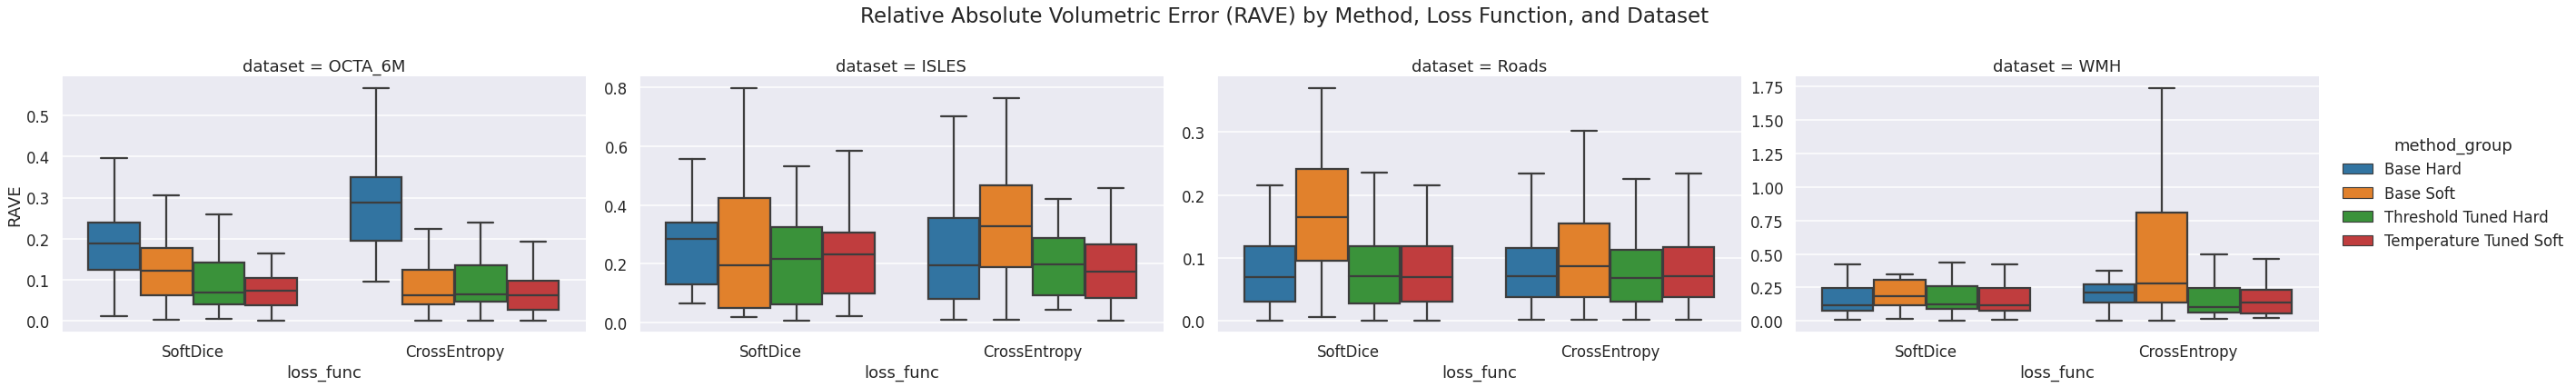

In [15]:
g = sns.catplot(
    val_analyis_df, 
    x='loss_func', 
    y='RAVE', 
    hue='method_group', 
    kind='box',
    col='dataset',
    aspect=1.5,
    height=6,
    showfliers=False,
    sharey=False
)
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle(f"Relative Absolute Volumetric Error (RAVE) by Method, Loss Function, and Dataset", fontsize=23)

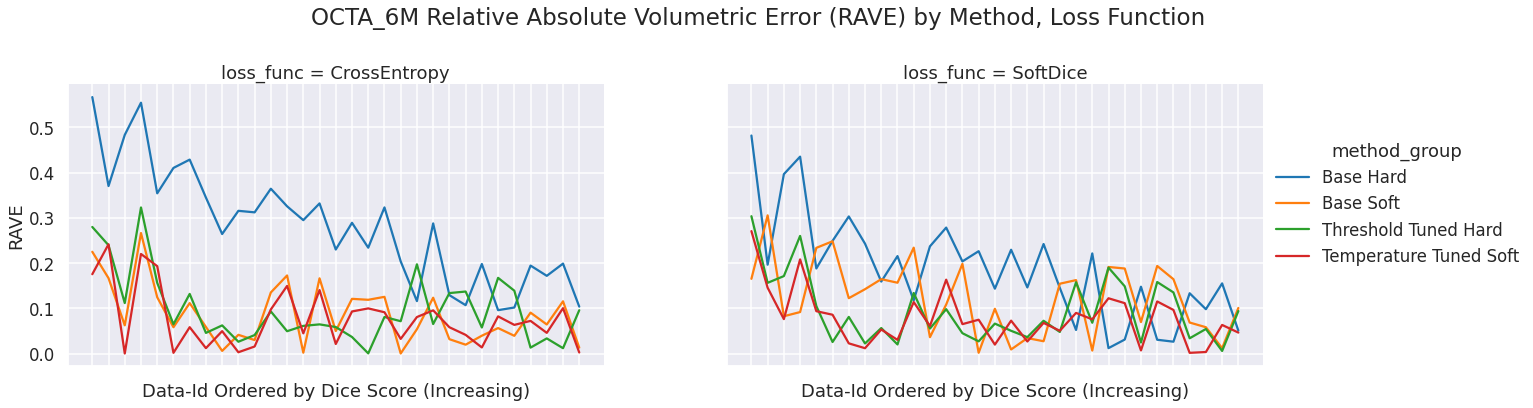

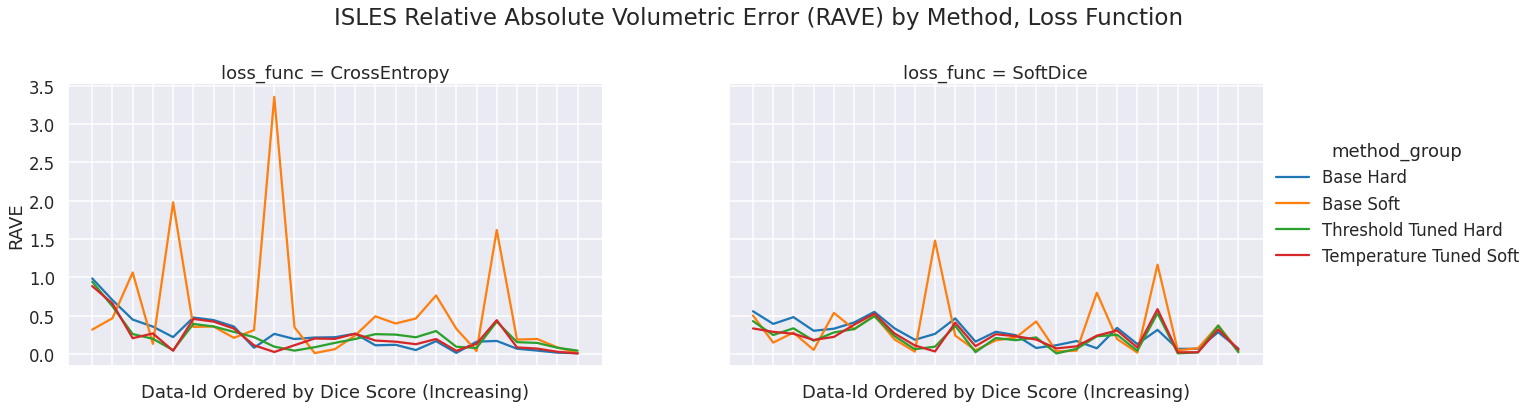

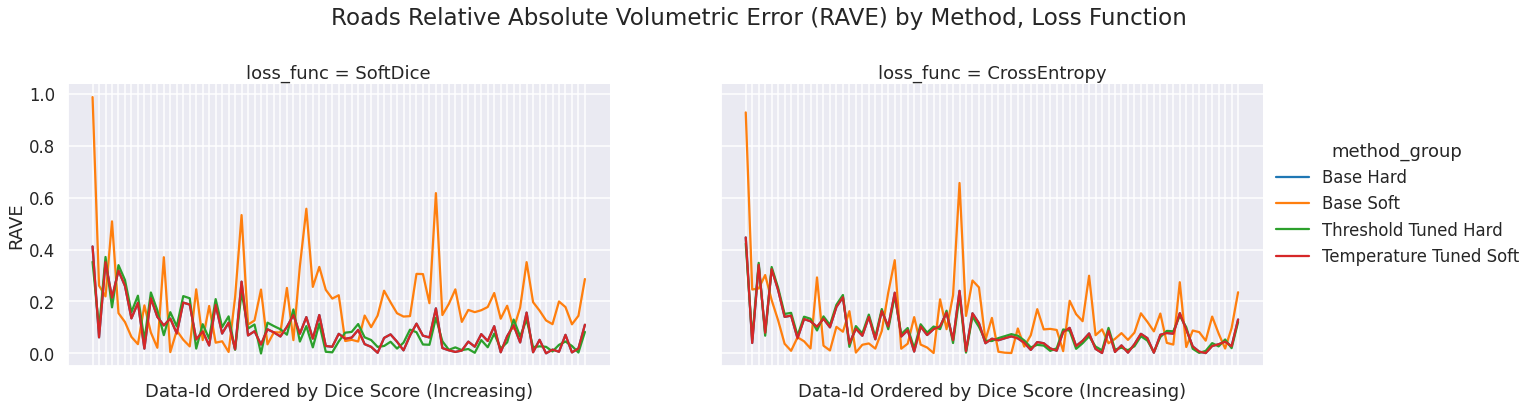

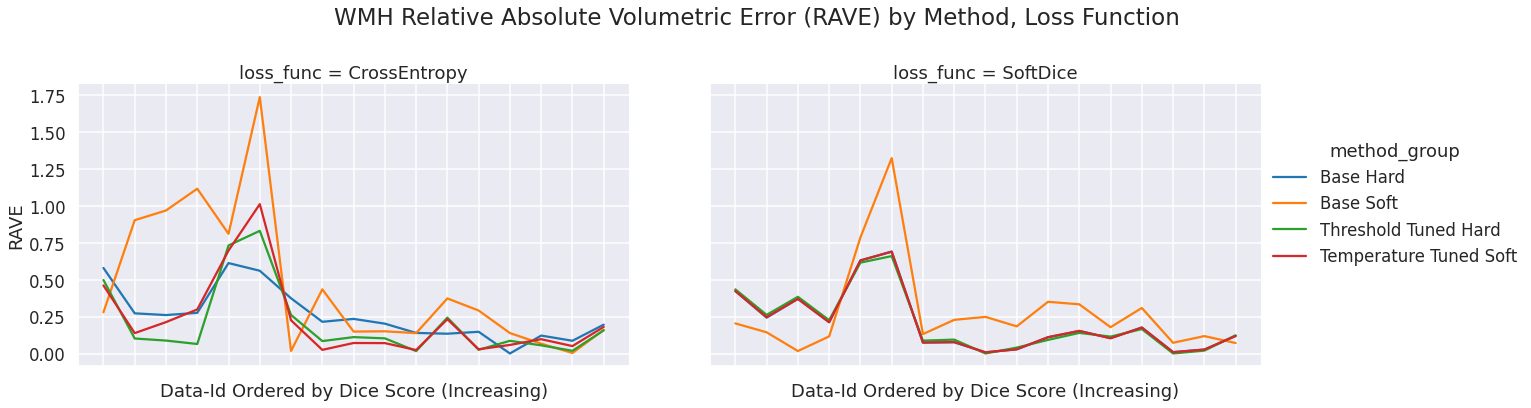

In [16]:
for dataset in val_analyis_df['dataset'].unique():

    # Get the rows corresponding to this dataset
    dataset_df = val_analyis_df[val_analyis_df['dataset'] == dataset]

    # Sort the rows by Dice
    dataset_df = dataset_df.sort_values(by='Dice', ascending=True)

    g = sns.relplot(
        dataset_df,
        x='data_id', 
        y='RAVE', 
        hue='method_group', 
        kind='line',
        col='loss_func',
        aspect=1.5,
        height=6,
    )
    # Disable x tick labels
    g.set(xticklabels=[])
    g.set_axis_labels("Data-Id Ordered by Dice Score (Increasing)", "RAVE")
    # We want to make a title for the plot, with some spacing 
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(f"{dataset} Relative Absolute Volumetric Error (RAVE) by Method, Loss Function", fontsize=23)
    plt.show()